# Runs the simulation of the data.
    
## INPUT: 

    * data/sim_data/splat_NODE.h5ad
    
## OUTPUT: 

    * data/sim_data/splat_MyDE.h5ad
    
## Environment Setup

In [4]:
work_dir = './' #Set to Cytocipher_manuscript/ location
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb

out_dir = 'data/sim_data/'
data_dir = out_dir

## Loading the noise scRNA-seq data

In [4]:
data = sc.read_h5ad(data_dir+'splat_NODE.h5ad')
data.shape

(3000, 10000)

## Setting up simulation

In [216]:
# Determining no. of cell per cell type
n_groups = 8
n_group_cells = data.shape[0]//n_groups
remaining = data.shape[0]-(n_groups*n_group_cells)
cells_per_group = np.array([n_group_cells]*n_groups)
cells_per_group[0:remaining] += 1

# Determing the no. of genes per cell type
min_de = 2
max_de = 7
total_de = 15

gene_indices = np.array(list(range(data.shape[1])))
de_indices = np.random.choice(gene_indices, total_de, replace=False)
de_gene_indices_per_group = []
for groupi in range(n_groups):
    n_de = np.random.choice(list(range(min_de, max_de)))
    
    de_indices_i = tuple(np.unique(np.random.choice(de_indices, n_de, replace=False)))
    while de_indices_i in de_gene_indices_per_group: # Make sure unique combination
        de_indices_i = tuple(np.unique(np.random.choice(de_indices, n_de, replace=False)))
        
    de_gene_indices_per_group.append( de_indices_i )
    
de_gene_indices_per_group

[(701, 823, 1879, 5670, 6480, 7433),
 (3093, 3791, 5670),
 (3093, 3775, 5065, 5670, 6480, 7273),
 (3093, 3791, 5670, 6870),
 (701, 3093, 5670, 7433),
 (392, 701, 823, 3775, 7273, 7433),
 (392, 1879, 3791, 5670, 7433, 7969),
 (392, 701, 3093, 5670, 6480, 7273)]

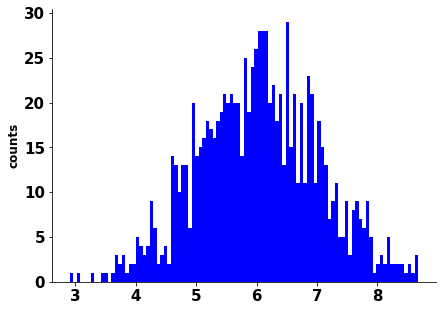

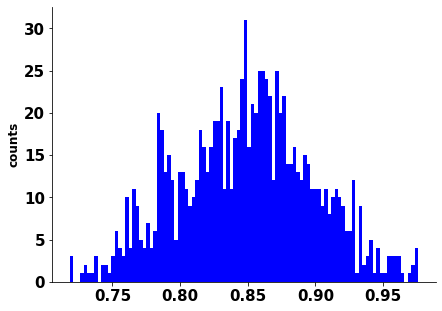

In [217]:
### Fold-changes
fcs = np.random.normal(6, 1, 1000)
fcs[fcs<1] = np.mean(fcs)
qpl.distrib(fcs)

#### Proportions in cell type
ct_props = np.random.normal(.85, .05, 1000)
ct_props[ct_props>1] = np.mean(ct_props)
ct_props[ct_props<0] = np.mean(ct_props)
qpl.distrib(ct_props)

### Proportions elsewhere.... will see if necessary..

In [218]:
def update_counts(gene_counts, prop_current, prop_target, fc):
    n_set = int( round(len(gene_counts) * (prop_target - prop_current)) )
    if n_set > 0: # Need to set 0 cells to counts
        cand_indices = np.where(gene_counts==0)[0]
    else:
        cand_indices = np.where(gene_counts>0)[0]
        
    set_indices = np.random.choice(cand_indices, np.abs(n_set), replace=False)
    replace_val = np.median( gene_counts[gene_counts!=0] ) if np.any(gene_counts!=0) else 1
    if n_set > 0: # Need to set 0 cells to counts
        gene_counts[set_indices] = replace_val
    else:
        gene_counts[set_indices] = 0
        
    return gene_counts * fc

In [219]:
# Getting counts
sim_counts = data.X.copy()

de_info_sim = {}
gene_indices = list(range(data.shape[1]))

remaining_indices = np.array(list(range(data.shape[0])))
cell_labels = np.array( ['Group           ']*data.shape[0] )

for groupi in range(n_groups):
    de_info_sim[f'Group{groupi}'] = {}
    ## Sampling cells for group
    group_indices = np.random.choice(remaining_indices, cells_per_group[groupi], replace=False)
    remaining_indices = [i for i in remaining_indices if i not in group_indices]
    cell_labels[group_indices] = f'Group{groupi}'
    other_indices = np.where(cell_labels!=f'Group{groupi}')[0]

    ## Sampling DE genes for group
    de_gene_indices = de_gene_indices_per_group[groupi]
    n_de = len(de_gene_indices)

    ## Getting DE stats
    fcs = np.random.choice(fcs, n_de)
    props = np.random.choice(ct_props, #[ct_props>.6], 
                             n_de)
    #otherprops = np.random.choice(otherct_props, #[otherct_props<.4], 
    #                              n_de)
    
    #print(otherprops)
    
    ## Now altering the simulated counts
    for i, gene_index in enumerate(de_gene_indices):
        gene_counts = sim_counts[group_indices, gene_index]
        #print(fcs[i])
        gene_counts_others = sim_counts[other_indices, gene_index]
        
        prop_expr = sum(gene_counts>0) / len(gene_counts)
        #prop_out = sum(gene_counts_others>0) / len(gene_counts_others)
        
        gene_counts_updated = update_counts(gene_counts, prop_expr, props[i], fcs[i])
        #other_counts_updated = update_counts(gene_counts_others, prop_out, otherprops[i], 1)
        
        ## Updating the counts ##
        sim_counts[group_indices, gene_index] = gene_counts_updated
        #sim_counts[other_indices, gene_index] = other_counts_updated
    
    ## Saving the DE gene information...
    de_info_sim[f'Group{groupi}']['de_gene_indices'] = de_gene_indices
    de_info_sim[f'Group{groupi}']['fcs'] = fcs
    de_info_sim[f'Group{groupi}']['props'] = props
    #de_info_sim[f'Group{groupi}']['otherprops'] = otherprops

In [220]:
de_info_sim

{'Group0': {'de_gene_indices': (701, 823, 1879, 5670, 6480, 7433),
  'fcs': array([5.91814167, 6.86828767, 4.71697   , 6.05203944, 4.029489  ,
         5.8384352 ]),
  'props': array([0.88463508, 0.95863452, 0.95863452, 0.7993084 , 0.90766083,
         0.87109844])},
 'Group1': {'de_gene_indices': (3093, 3791, 5670),
  'fcs': array([6.05203944, 6.86828767, 5.91814167]),
  'props': array([0.91814568, 0.85916129, 0.86189788])},
 'Group2': {'de_gene_indices': (3093, 3775, 5065, 5670, 6480, 7273),
  'fcs': array([6.86828767, 5.91814167, 6.86828767, 5.91814167, 6.86828767,
         5.91814167]),
  'props': array([0.86128378, 0.89298655, 0.82024451, 0.91685005, 0.93985926,
         0.90977466])},
 'Group3': {'de_gene_indices': (3093, 3791, 5670, 6870),
  'fcs': array([5.91814167, 6.86828767, 5.91814167, 6.86828767]),
  'props': array([0.92346226, 0.87902167, 0.8321187 , 0.75210606])},
 'Group4': {'de_gene_indices': (701, 3093, 5670, 7433),
  'fcs': array([5.91814167, 5.91814167, 5.91814167, 

## Making anndata and preprocessing

In [221]:
for groupi in range(n_groups):
    de_info_sim[f'Group{groupi}']['de_gene_indices'] = list(de_info_sim[f'Group{groupi}']['de_gene_indices'])
    de_genes = data.var_names.values[ de_info_sim[f'Group{groupi}']['de_gene_indices'] ]
    de_info_sim[f'Group{groupi}']['de_genes'] = de_genes.astype(str)

In [222]:
new_data = sc.AnnData(sim_counts.astype(int), obs=data.obs, var=data.var)
new_data.layers['counts'] = new_data.X

new_data.obs['cell_type'] = cell_labels
new_data.uns['de_info_sim'] = de_info_sim

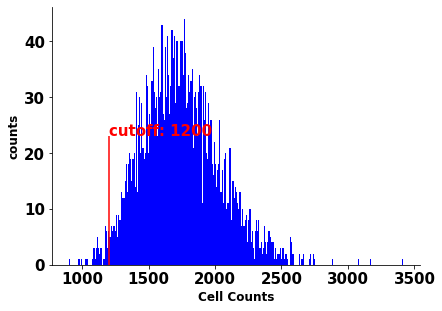

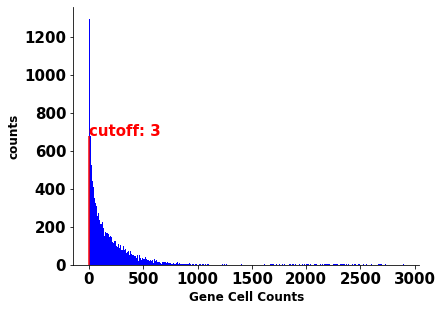

In [223]:
sc.pp.calculate_qc_metrics(new_data, percent_top=None, log1p=False, inplace=True)

counts_cutoff = 1200
genes_cutoff = 3
qpl.distrib(new_data.obs['total_counts'].values, cutoff=counts_cutoff,
            x_label='Cell Counts', bins=300)
qpl.distrib(new_data.var['n_cells_by_counts'].values, cutoff=genes_cutoff,
            x_label='Gene Cell Counts', bins=300)

In [224]:
sc.pp.normalize_total(new_data)
sc.pp.log1p(new_data)

In [225]:
new_data.uns['de_info_sim'][group].keys()

dict_keys(['de_gene_indices', 'fcs', 'props', 'de_genes'])

In [226]:
group_to_de = {}
all_de_genes = []
for groupi in range(len(new_data.uns['de_info_sim'])):
    group = f'Group{groupi}'
    fcs = new_data.uns['de_info_sim'][group]['fcs']
    order = np.argsort(-fcs)
    de_genes = new_data.uns['de_info_sim'][group]['de_genes']
    group_to_de[group] = de_genes[order[0:3]] # Just top 3 genes
    all_de_genes.extend(de_genes)
    
all_de_bool = [gene in all_de_genes for gene in new_data.var_names]
new_data.var['de_gene'] = all_de_bool 

In [227]:
group_to_de

{'Group0': array(['Gene824', 'Gene5671', 'Gene702'], dtype='<U8'),
 'Group1': array(['Gene3792', 'Gene3094', 'Gene5671'], dtype='<U8'),
 'Group2': array(['Gene3094', 'Gene5066', 'Gene6481'], dtype='<U8'),
 'Group3': array(['Gene3792', 'Gene6871', 'Gene3094'], dtype='<U8'),
 'Group4': array(['Gene7434', 'Gene702', 'Gene3094'], dtype='<U8'),
 'Group5': array(['Gene393', 'Gene702', 'Gene824'], dtype='<U8'),
 'Group6': array(['Gene393', 'Gene1880', 'Gene3792'], dtype='<U8'),
 'Group7': array(['Gene393', 'Gene702', 'Gene3094'], dtype='<U8')}

In [228]:
sc.tl.pca(new_data)
sc.pp.neighbors(new_data)
sc.tl.umap(new_data)

In [229]:
###### Saving results
new_data.write_h5ad(out_dir+'splat_MyDE.h5ad', compression='gzip')

/Users/uqbbalde/opt/miniconda3/envs/hypo_atlas/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


## Visualising DE results

In [6]:
import anndata as ad
ad.__version__

'0.7.8'

In [2]:
new_data = sc.read_h5ad(out_dir+'splat_MyDE.h5ad')

In [3]:
new_data.shape

(3000, 10000)

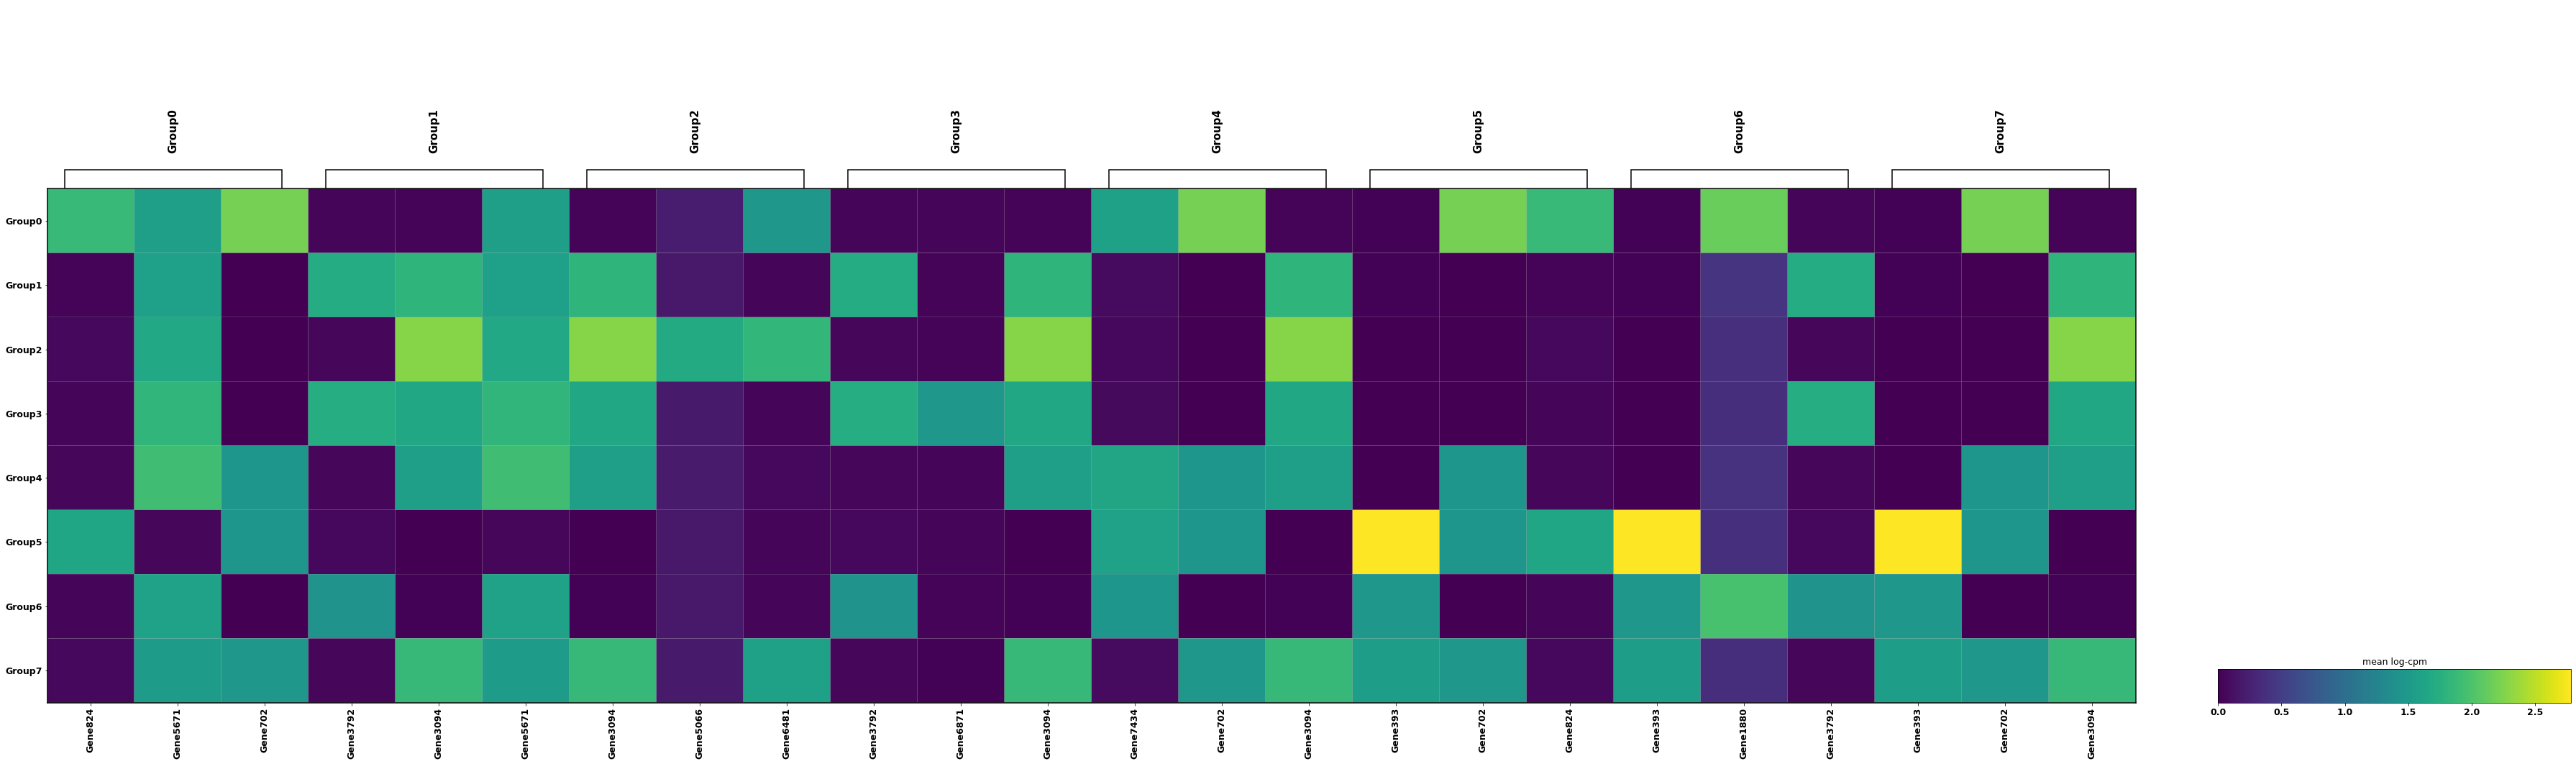

In [230]:
matplotlib.rcParams.update({'font.size': 15}) 
figsize=(50,15)
fig, ax = plt.subplots(figsize=figsize)
sc.pl.matrixplot(new_data, group_to_de, 'cell_type', dendrogram=False, return_fig=False,
                       colorbar_title='mean log-cpm', ax=ax, use_raw=False, show=False)
plt.show()

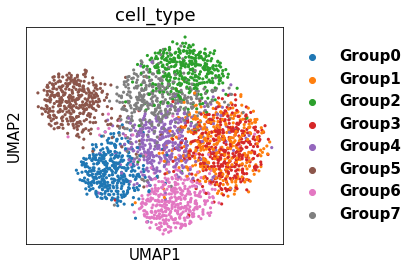

In [231]:
sc.pl.umap(new_data, color='cell_type', show=False)
plt.show()

In [234]:
print(len(np.unique(all_de_genes)))

14


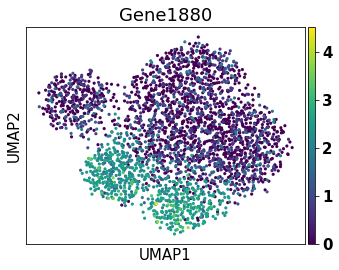

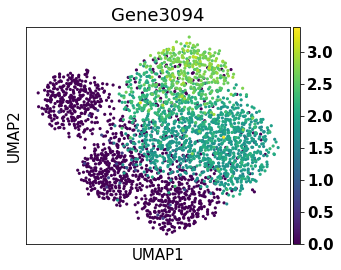

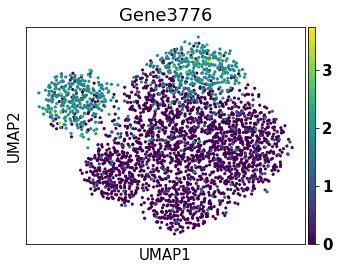

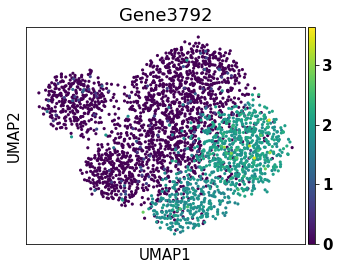

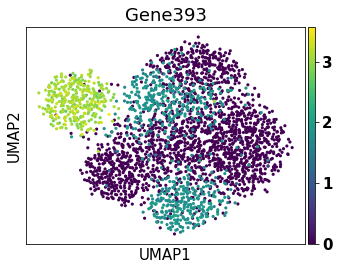

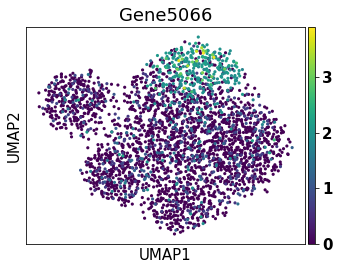

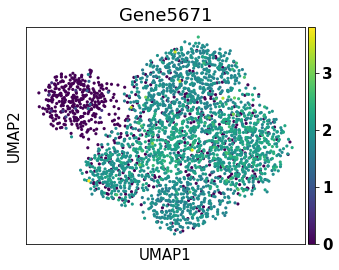

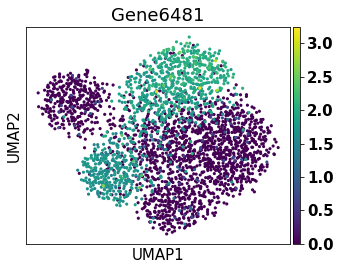

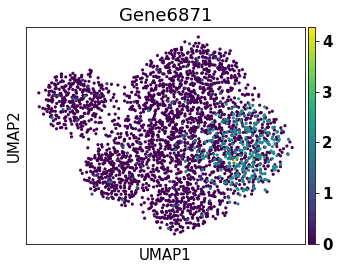

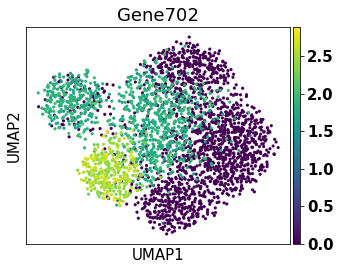

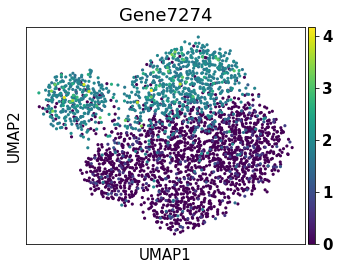

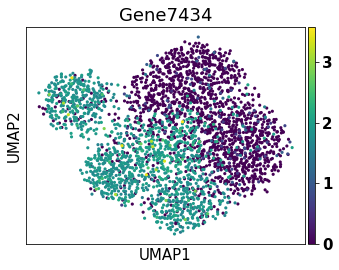

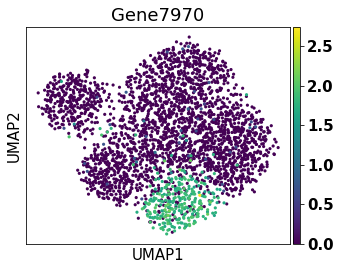

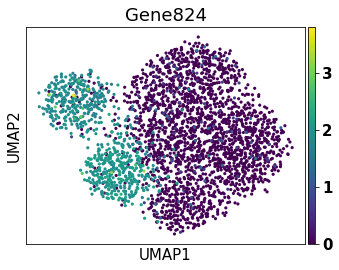

In [235]:
for gene in np.unique(all_de_genes):
    fig, ax = plt.subplots(figsize=(5,4))
    sc.pl.umap(new_data, color=gene, show=False, ax=ax, legend_loc=None)
    plot.show()